<table align="center">
   <td align="center"><a target="_blank" href="https://colab.research.google.com/github/umbcdata602/fall2020/blob/master/lab_lsa.ipynb">
<img src="http://introtodeeplearning.com/images/colab/colab.png?v2.0"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
</table>

# Lab: LSA (Latent Semantic Analysis)

Ref: Bonaccorso, Chapter 14, *Topic Modeling and Sentiment Analysis in NLP*

* [lsa.py](https://github.com/giuseppebonaccorso/Machine-Learning-Algorithms-Second-Edition/blob/master/Chapter14/lsa.py) -- github
* [lsa_1.py](https://github.com/giuseppebonaccorso/Machine-Learning-Algorithms-Second-Edition/blob/master/Chapter14/lsa_1.py) -- github
* [lsa_2.py](https://github.com/giuseppebonaccorso/Machine-Learning-Algorithms-Second-Edition/blob/master/Chapter14/lsa_2.py) -- github

### References

* *Machine Learning Algorithms, 2nd Ed*, 2018, Giuseppe Bonaccorso, Packt
* [NLTK](https://www.nltk.org/) -- nltk.org
  * [installing data](https://www.nltk.org/data.html) -- nltk.org
  * [corpora](https://www.nltk.org/book/ch02.html) -- nltk.org
  * [*Natural Language Processing with Python*](https://www.nltk.org/book/) (book updated for Python 3) -- nltk.org
  * [text corpora](https://www.nltk.org/book/ch02.html) (chapter 2 of NLTK book) -- nltk.org
* [Brown corpus manual](http://icame.uib.no/brown/bcm.html)
    * [list of samples](http://icame.uib.no/brown/bcm-los.html)

In [1]:
2**21

2097152

### Topic modeling

* The goal for topic modeling in NLP: analyze a corpus and identify common topics
* Topic: implies use of common words in a document and confirmed by multiple documents
* Semantic purpose is presumed to exist but is not part of the analysis
* Starting point is an occurrence matrix



# NLTK

The Brown corpus -- the first million-word electronic corpus of English created in 1961 at Brown University.

In [2]:
# Install NLTK and the Brown corpus
import nltk
from nltk.corpus import brown

nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

# Lazy evaluation

Investigate the objects we downloaded from NLTK

In [3]:
# What did we download?
print(type(brown))
sentences = brown.sents(categories=['news'])[0:500]
print(type(sentences))

<class 'nltk.corpus.util.LazyCorpusLoader'>
<class 'nltk.collections.LazySubsequence'>


In [4]:
!ls /root/nltk_data/*
!du -h /root/nltk_data/*

brown  brown.zip
11M	/root/nltk_data/corpora/brown
14M	/root/nltk_data/corpora


In [5]:
print(brown.categories())

['adventure', 'belles_lettres', 'editorial', 'fiction', 'government', 'hobbies', 'humor', 'learned', 'lore', 'mystery', 'news', 'religion', 'reviews', 'romance', 'science_fiction']


In [6]:
sentences = brown.sents(categories=['news'])[0:500]
type(sentences)
for k in range(3):
    print(' '.join(sentences[k]))

The Fulton County Grand Jury said Friday an investigation of Atlanta's recent primary election produced `` no evidence '' that any irregularities took place .
The jury further said in term-end presentments that the City Executive Committee , which had over-all charge of the election , `` deserves the praise and thanks of the City of Atlanta '' for the manner in which the election was conducted .
The September-October term jury had been charged by Fulton Superior Court Judge Durwood Pye to investigate reports of possible `` irregularities '' in the hard-fought primary which was won by Mayor-nominate Ivan Allen Jr. .


# LSA theory

Bonaccorso introduces the n-by-m document-term matrix $\mathbf{M}$, where $M_{dw}$ represents is the term in row $d$ and column $w$. $\mathbf{M}$ represents a corpus of $n$ documents and a vocabulary of $m$ terms. The actual value of $M_{dw}$ could be a measure (e.g., tf-idf) of the frequency with with the term $w$ appears in document $d$.

LSA involves the SVD of $\mathbf{M}$,

$$
\mathbf{M} = \mathbf{USV}^T = \mathbf{DW}
$$

where the matrix $\mathbf{D} = \mathbf{US}$ and $\mathbf{W} = \mathbf{V}$. 

* Element $D_{d,k}$ of $\mathbf{D}$ relates document $d$ to topic $k$.

* Element $V_{k,w}$ relates topic $k$ to term $w$.

So if we want to consider a reduced dimensional version of $\mathbf{D}$, then we can consider only the $K$ most important eigenvalues.

The eigenvalues (the diagonal values $S_{kk}$ of $\mathbf{S}$) are called "latent variables" because they are not actually "observed".

The code in the next few sections shows results for the top $K=2$ topics. The plots show the clustering of documents according to the two 2 topics.  And the top 10 words associated with the top two topics are printed using the lookup table to associate element $V_{t,w}$ with the appropriate word.

# lsa.py

Produces the figure on p400


Topic 0
plainfield
wasn
football
letterman
team
basketball
captain
james
patrolman
corps

Topic 1
plainfield
wasn
released
copy
absence
africa
circumstances
emotionally
disapprove
facing

Sample document:
The Fulton County Grand Jury said Friday an investigation of Atlanta's recent primary election produced `` no evidence '' that any irregularities took place .

Sample document in the topic sub-space:
d0 = 0.15*t1 + -0.12*t2


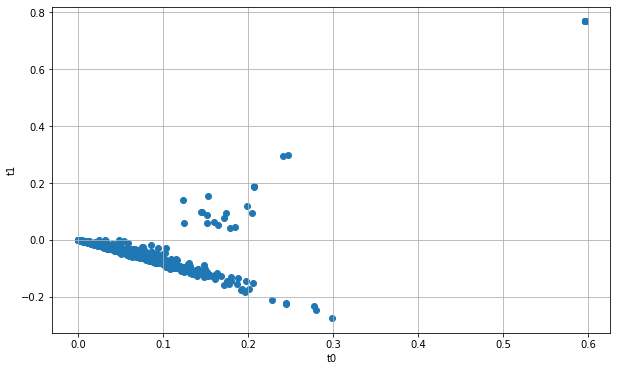

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import brown

from scipy.linalg import svd

from sklearn.feature_extraction.text import TfidfVectorizer


# For reproducibility
np.random.seed(1000)


def scatter_documents(X):
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    ax.scatter(X[:, 0], X[:, 1])
    ax.set_xlabel('t0')
    ax.set_ylabel('t1')
    ax.grid()
    plt.show()

# Compose a corpus
# This 500-sentence dataset reproduces the figure on p400
sentences = brown.sents(categories=['news'])[0:500]

#########################################
# WARNING: If you uncomment this version, it takes ~20 minutes to run in Colab
# This uses two complete categories (total length ~8K)
# This will reproduce the figure on p401
##########################################
# sentences = sentences = brown.sents(categories=['news', 'fiction'])

corpus = []

for s in sentences:
    corpus.append(' '.join(s))

# Vectorize the corpus
vectorizer = TfidfVectorizer(strip_accents='unicode', stop_words='english', sublinear_tf=True, use_idf=True)
Xc = vectorizer.fit_transform(corpus).todense()

# Perform SVD
U, s, V = svd(Xc, full_matrices=False)

# Extract a sub-space with rank=2
rank = 2

Uk = U[:, 0:rank]
sk = np.diag(s)[0:rank, 0:rank]
Vk = V[0:rank, :]

# Check the top-10 word per topic
Mwts = np.argsort(np.abs(Vk), axis=1)[::-1]

for t in range(rank):
    print('\nTopic ' + str(t))
    for i in range(10):
        print(vectorizer.get_feature_names()[Mwts[t, i]])

# Compute the structure of a document
print('\nSample document:')
print(corpus[0])

Mdtk = Uk.dot(sk)
print('\nSample document in the topic sub-space:')
print('d0 = %.2f*t1 + %.2f*t2' % (Mdtk[0][0], Mdtk[0][1]))

# Show a scatter plot of all documents
scatter_documents(Mdtk)

# lsa_2.py

* This uses two complete categories (total length ~8K)
* This will reproduce the figure on p401
* This uses TruncatedSVD for rank 2 -- It runs very fast.
* If you use the same corpus in the first cell, it'll take ~20 minutes in colab



Topic 0
said
rector
hans
aloud
liston
nonsense
leave
whiskey
chicken
fat

Topic 1
bong
varnessa
schoolboy
kaboom
keeeerist
aggravated
jealous
hides
mayonnaise
fowl


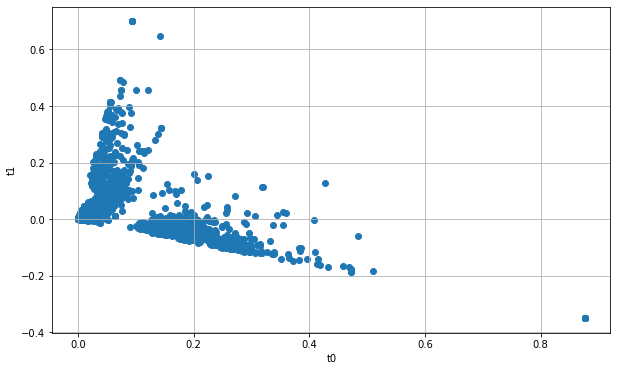

In [8]:
from sklearn.decomposition import TruncatedSVD

# For reproducibility
np.random.seed(1000)

# Compose a corpus
sentences = sentences = brown.sents(categories=['news', 'fiction'])
corpus = []

for s in sentences:
    corpus.append(' '.join(s))

# Vectorize the corpus
vectorizer = TfidfVectorizer(strip_accents='unicode', stop_words='english', sublinear_tf=True, use_idf=True)
Xc = vectorizer.fit_transform(corpus)

rank = 2

# Performed a truncated SVD
tsvd = TruncatedSVD(n_components=rank)
Xt = tsvd.fit_transform(Xc)

# Check the top-10 word per topic
Mwts = np.argsort(tsvd.components_, axis=1)[::-1]

for t in range(rank):
    print('\nTopic ' + str(t))
    for i in range(10):
        print(vectorizer.get_feature_names()[Mwts[t, i]])

# Show a scatter plot of all documents
scatter_documents(Xt)